# HealingNYC
## MTA and opioid analysis

In [1]:
import pandas as pd
import datetime
import geopandas
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import inspect
from shapely import wkt
import contextily as ctx

### **MTA data cleaning**

This code will load in the MTA data from the MTA website or from a local directory.

In [583]:
# Source: http://web.mta.info/developers/turnstile.html
#def get_data(week_nums,local=False):
#    if local:
#        url = "turnstile_{}.txt"
#    else:
#        url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
#    dfs = []
#    for week_num in week_nums:
#        file_url = url.format(week_num)
#        dfs.append(pd.read_csv(file_url))
#    return pd.concat(dfs)


#week_nums = [210703, 210710,210717,210724,210731,210807, 210814,210821,210828,210904,210911,210918,210925]
#turnstiles_df = get_data(week_nums)

Instead load from a local SQL database

In [2]:
engine = create_engine("sqlite:///mta_data.db")
turnstiles_df = pd.read_sql("SELECT * FROM mta_data", engine)

In [3]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,00:00:00,REGULAR,7637026,2613455
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,04:00:00,REGULAR,7637036,2613457
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,08:00:00,REGULAR,7637047,2613478
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,12:00:00,REGULAR,7637104,2613524
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,16:00:00,REGULAR,7637236,2613561


In [4]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [5]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [6]:
# Three months (91 days) of Data
len(turnstiles_df.DATE.unique())

91

In [7]:
# Take the date and time fields into a single datetime column
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [8]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,00:00:00,REGULAR,7637026,2613455,2021-09-18 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,04:00:00,REGULAR,7637036,2613457,2021-09-18 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,08:00:00,REGULAR,7637047,2613478,2021-09-18 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,12:00:00,REGULAR,7637104,2613524,2021-09-18 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/18/2021,16:00:00,REGULAR,7637236,2613561,2021-09-18 16:00:00


In [9]:
# There are no duplicate entries
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
2702968,S101,R070,00-00-02,ST. GEORGE,2021-09-16 08:00:00,2
2702884,S101,R070,00-00-02,ST. GEORGE,2021-09-02 16:00:00,2
2455849,R516,R291,00-00-00,33 ST-RAWSON ST,2021-08-24 16:00:00,2
1390007,N535,R220,00-00-01,CARROLL ST,2021-08-31 16:00:00,2
1389458,N535,R220,00-00-00,CARROLL ST,2021-08-31 16:00:00,2


In [10]:
#It's due multiple RECOVR AUD readings, rather than REGULAR (normally scheduled one)

#turnstiles_df.DESC.value_counts()

In [11]:
# Remove duplicate entries
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [12]:
# Now there are no duplicate entries
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-06-26 00:00:00,1
1816191,R139,R031,04-00-00,34 ST-PENN STA,2021-09-05 12:00:00,1
1816193,R139,R031,04-00-00,34 ST-PENN STA,2021-09-05 20:00:00,1
1816194,R139,R031,04-00-00,34 ST-PENN STA,2021-09-06 00:00:00,1
1816195,R139,R031,04-00-00,34 ST-PENN STA,2021-09-06 04:00:00,1


In [13]:
# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

Find the daily number of entries by turnstile

In [14]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                       .apply(lambda grp: grp.shift(1)))

In [15]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,06/26/2021,7593116,NaN,NaN
1,A002,R051,02-00-00,59 ST,06/27/2021,7593427,06/26/2021,7593116.0
2,A002,R051,02-00-00,59 ST,06/28/2021,7593979,06/27/2021,7593427.0
3,A002,R051,02-00-00,59 ST,06/29/2021,7594528,06/28/2021,7593979.0
4,A002,R051,02-00-00,59 ST,06/30/2021,7595154,06/29/2021,7594528.0


In [16]:
turnstiles_daily.tail()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
454570,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/20/2021,5554,09/19/2021,5554.0
454571,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/21/2021,5554,09/20/2021,5554.0
454572,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/22/2021,5554,09/21/2021,5554.0
454573,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/23/2021,5554,09/22/2021,5554.0
454574,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/24/2021,5554,09/23/2021,5554.0


In [17]:
# Drop the rows for the earliest date in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

### Reverse Entries

Next, let's look at some more weirdness in the data and think about handling it before we finalize our daily count column

In [18]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
3550,A011,R080,01-03-00,57 ST-7 AV,06/27/2021,885594879,06/26/2021,885595097.0
3551,A011,R080,01-03-00,57 ST-7 AV,06/28/2021,885594609,06/27/2021,885594879.0
3552,A011,R080,01-03-00,57 ST-7 AV,06/29/2021,885594336,06/28/2021,885594609.0
3553,A011,R080,01-03-00,57 ST-7 AV,06/30/2021,885594053,06/29/2021,885594336.0
3554,A011,R080,01-03-00,57 ST-7 AV,07/01/2021,885593780,06/30/2021,885594053.0


* Counter working in Reverse??? 

In [19]:
# Let's see how many stations have this problem

(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A011  R080  01-03-00  57 ST-7 AV         90
A013  R081  01-06-01  49 ST               1
A014  R081  02-00-00  49 ST               1
A049  R088  02-05-00  CORTLANDT ST       23
A066  R118  00-00-00  CANAL ST           90
                                         ..
R622  R123  00-00-00  FRANKLIN AV        90
R633  R068  00-00-01  VAN SICLEN AV       1
R646  R110  01-00-02  FLATBUSH AV-B.C     1
R730  R431  00-00-04  EASTCHSTER/DYRE    89
S101  R070  00-00-02  ST. GEORGE          5
Length: 198, dtype: int64

In [20]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=90000)

393216 1.0
5 150038.0
353 8049630.0
12 468610.0
167790157 702266.0
310 5609562.0
351 132517.0
35 9768753.0
33565227 188178.0
48 8724126.0
458768 2578.0
65 106396.0
100 91332.0
1064 150473.0
393216 728.0
511 3272795.0
284 124319.0
5946 4298704.0
0 117440512.0
83 366981.0
331 500527.0
327975 7577027.0
85 490316.0
67109632 14.0
327682 67109640.0
15 67109632.0
36 1198448.0
103 305512.0
46 5405351.0
200 705357551.0
16777220 1037157.0
6 16034831.0
974 197582.0
458814 271001.0
327682 786526.0
327680 0.0
386 6213955.0
442 656520.0
37 1950780.0
443 15689395.0
772 239100.0
421 114067.0
609994 1021.0
1606 609994.0
1193 117404.0
458 182438.0
628 97038.0
220 624575.0
7329 430115.0
134 226543.0
512 99609.0
108 277764.0
500 118845.0
2 146227.0
316 319276.0
8 1255797.0
21 120055.0
240 993695.0
7 201369.0
589899 393607.0
138 380611.0
5 11123659.0
256 3153907.0
126 3102523.0
403 315741.0
389 509445.0
0 458872.0
360 408702.0
393271 29099.0
19 2570919.0
50362839 251769.0
114 1953264.0
169 4788322.0
393624

In [21]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,06/27/2021,7593427,06/26/2021,7593116.0,311.0
2,A002,R051,02-00-00,59 ST,06/28/2021,7593979,06/27/2021,7593427.0,552.0
3,A002,R051,02-00-00,59 ST,06/29/2021,7594528,06/28/2021,7593979.0,549.0
4,A002,R051,02-00-00,59 ST,06/30/2021,7595154,06/29/2021,7594528.0,626.0
5,A002,R051,02-00-00,59 ST,07/01/2021,7595703,06/30/2021,7595154.0,549.0


Group now by groups of turnstiles (so one compination of C/A, UNIT, STATION)

In [22]:
ca_unit_station_daily = turnstiles_daily.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
ca_unit_station_daily.head()

,C/A,UNIT,STATION,DATE,DAILY_ENTRIES
0,A002,R051,59 ST,06/27/2021,2499.0
1,A002,R051,59 ST,06/28/2021,4569.0
2,A002,R051,59 ST,06/29/2021,4842.0
3,A002,R051,59 ST,06/30/2021,5016.0
4,A002,R051,59 ST,07/01/2021,4803.0


Find number of entires for each station for each day

In [23]:
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,06/27/2021,6835.0
1,1 AV,06/28/2021,7529.0
2,1 AV,06/29/2021,7231.0
3,1 AV,06/30/2021,7588.0
4,1 AV,07/01/2021,7687.0


Find the total number of entries over the three months of data we have for each station.

Then sort to find the top 10 most trafficed stations over this time period.

In [24]:
station_totals = station_daily.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()

station_totals.head(20)

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,4100642.0
1,34 ST-HERALD SQ,3079289.0
2,GRD CNTRL-42 ST,2878610.0
3,42 ST-PORT AUTH,2777623.0
4,23 ST,2633567.0
5,86 ST,2613764.0
6,14 ST-UNION SQ,2528520.0
7,125 ST,2439773.0
8,TIMES SQ-42 ST,2291661.0
9,FLUSHING-MAIN,2178869.0


### **Opioid mortality data**



In [25]:
#Source can be found at https://www.health.ny.gov/statistics/opioid/

local = True
if local:
    url = "OP-CountyTrendData.xlsx"
else:
    url = "https://webbi1.health.ny.gov/SASStoredProcess/DOHSTAT/dohPublic/pix/OP-CountyTrendData.xlsx"
    
#Skip top 2 blank lines, verify this if source is updated
op_raw = pd.read_excel(url, header =2)
op_raw.head(2)

,County Name,Priority Area Number,Priority Area,Indicator Number,Indicator,Event Count/Rate,Average Number of Denominator/Rate,Percentage/Rate/Ratio,Lower Limit of 95% CI,Upper Limit of 95% CI,Data Comments,Data Years,Date Source
0,Albany,1,Opioid Data Overview,op51,"Overdose deaths involving any opioid, crude ra...",15,304078.0,4.9,NaN,NaN,NaN,2010,Vital Statistics Data as of August 2020
1,Allegany,1,Opioid Data Overview,op51,"Overdose deaths involving any opioid, crude ra...",3,48962.0,6.1,NaN,NaN,Unstable Estimate,2010,Vital Statistics Data as of August 2020


In [26]:
#Data contains counts for various opioid-related events

print(op_raw.Indicator.unique()[0:4])
print(len(op_raw.Indicator.unique()))

['Overdose deaths involving any opioid, crude rate per 100,000 population'
 'Unique naloxone administrations by EMS agencies, crude rate per 1,000 unique 911 EMS dispatches'
 'Opioid analgesics prescription, crude rate per 1,000 population'
 'Opioid analgesics prescription, age-adjusted rate per 1,000 population']
66


Focus on overdose deaths due to opioid (per 100,000)

In [27]:
op_df = op_raw[op_raw.Indicator == "Overdose deaths involving any opioid, crude rate per 100,000 population"]
op_df.head(2)

,County Name,Priority Area Number,Priority Area,Indicator Number,Indicator,Event Count/Rate,Average Number of Denominator/Rate,Percentage/Rate/Ratio,Lower Limit of 95% CI,Upper Limit of 95% CI,Data Comments,Data Years,Date Source
0,Albany,1,Opioid Data Overview,op51,"Overdose deaths involving any opioid, crude ra...",15,304078.0,4.9,NaN,NaN,NaN,2010,Vital Statistics Data as of August 2020
1,Allegany,1,Opioid Data Overview,op51,"Overdose deaths involving any opioid, crude ra...",3,48962.0,6.1,NaN,NaN,Unstable Estimate,2010,Vital Statistics Data as of August 2020


Each row is the data for one county for one year. This data is for the whole state of New York, but each borough of NYC is a county, so we can use that.

Now choose the columns of interest, in particular:

- Name of the county, which is the borough
- Raw count of deaths due to opioid overdoes
- Population
- Deaths due to opioid overdoes per 100000 population
- Year


In [28]:
op_df = op_df.loc[:,["County Name", "Event Count/Rate", "Average Number of Denominator/Rate", 
                    "Percentage/Rate/Ratio", "Data Years", "Data Comments"]]

col_dict = {"County Name":"county", "Event Count/Rate":"death_count", "Average Number of Denominator/Rate":"pop",
           "Percentage/Rate/Ratio":"deaths_per_100k","Data Years":"year", "Data Comments":"notes"}

op_df.rename(columns = col_dict, inplace=True)
op_df.head()

,county,death_count,pop,deaths_per_100k,year,notes
0,Albany,15,304078.0,4.9,2010,NaN
1,Allegany,3,48962.0,6.1,2010,Unstable Estimate
2,Broome,10,200478.0,5,2010,NaN
3,Cattaraugus,1,80230.0,1.2,2010,Unstable Estimate
4,Cayuga,7,79901.0,8.8,2010,Unstable Estimate


Choose only the rows corresponding to NYC boroughs, leave off Staten Island, since we don't have locations for the Staten Island stations

In [29]:
#Dictionary maps county name to Borough name

county2boro = {"Bronx":"Bronx","New York":"Manhattan","Queens":"Queens","Kings":"Brooklyn"}
                #"Richmond":"Staten Island"
op_df = op_df[op_df.county.isin(county2boro.keys())]
op_df.tail()

,county,death_count,pop,deaths_per_100k,year,notes
8385,Queens,219,2296865.0,9.5,2017,NaN
8457,Bronx,313,1432132.0,21.9,2018,NaN
8458,Kings,218,2582830.0,8.4,2018,NaN
8459,New York,204,1628701.0,12.5,2018,NaN
8460,Queens,186,2278906.0,8.2,2018,NaN


In [30]:
op_df.groupby(["county","year"]).pop.count()

county    year
Bronx     2010    2
          2011    2
          2012    2
          2013    2
          2014    2
          2015    2
          2016    2
          2017    2
          2018    2
Kings     2010    2
          2011    2
          2012    2
          2013    2
          2014    2
          2015    2
          2016    2
          2017    2
          2018    2
New York  2010    2
          2011    2
          2012    2
          2013    2
          2014    2
          2015    2
          2016    2
          2017    2
          2018    2
Queens    2010    2
          2011    2
          2012    2
          2013    2
          2014    2
          2015    2
          2016    2
          2017    2
          2018    2
Name: pop, dtype: int64

There are two rows for each borough/year (different data sources). Remove the duplicate rows.

In [31]:
op_df.drop_duplicates(inplace=True)
op_df.shape

(36, 6)

Add a column for the borough name

In [32]:
op_df["boro"] = op_df.county.map(county2boro)
op_df.head()

,county,death_count,pop,deaths_per_100k,year,notes,boro
57,Bronx,71,1387353.0,5.1,2010,NaN,Bronx
58,Kings,130,2509877.0,5.2,2010,NaN,Brooklyn
59,New York,50,1588759.0,3.1,2010,NaN,Manhattan
60,Queens,87,2234745.0,3.9,2010,NaN,Queens
132,Bronx,93,1397366.0,6.7,2011,NaN,Bronx


### **Geodata for NY boroughs**

Access the geodata for NYC boroughs from Geopandas.

In [33]:
boro_path = geopandas.datasets.get_path("nybb")
boro_df = geopandas.read_file(boro_path)
boro_df.set_index("BoroName", inplace=True)

boro_df

,BoroCode,Shape_Leng,Shape_Area,geometry
BoroName,,,,
Staten Island,5,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
Queens,4,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
Brooklyn,3,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
Manhattan,1,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
Bronx,2,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


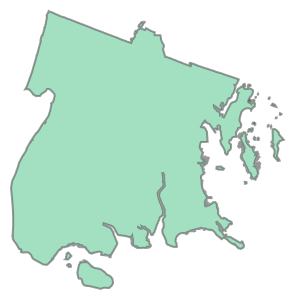

In [34]:
boro_df.loc["Bronx","geometry"]

In [35]:
boro_df = boro_df.to_crs("EPSG:4326")
boro_df

,BoroCode,Shape_Leng,Shape_Area,geometry
BoroName,,,,
Staten Island,5,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
Queens,4,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
Brooklyn,3,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
Manhattan,1,359299.096471,6.364715e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
Bronx,2,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


### **Station location data**

Now we get the geodata for locations of the station entrances.

In [36]:
#Source: https://data.cityofnewyork.us/api/views/kk4q-3rt2/rows.csv
local = True

if local:
    url = "station_location.csv"
else:
    url= "https://data.cityofnewyork.us/api/views/kk4q-3rt2/rows.csv"
    
location_df = geopandas.read_file(url)
location_df.head()

,URL,OBJECTID,NAME,the_geom,LINE,NOTES,geometry
0,http://web.mta.info/nyct/service/,1,Astor Pl,POINT (-73.99106999861966 40.73005400028978),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",None
1,http://web.mta.info/nyct/service/,2,Canal St,POINT (-74.00019299927328 40.71880300107709),4-6-6 Express,"4 nights, 6-all times, 6 Express-weekdays AM s...",None
2,http://web.mta.info/nyct/service/,3,50th St,POINT (-73.98384899986625 40.76172799961419),1-2,"1-all times, 2-nights",None
3,http://web.mta.info/nyct/service/,4,Bergen St,POINT (-73.97499915116808 40.68086213682956),2-3-4,"4-nights, 3-all other times, 2-all times",None
4,http://web.mta.info/nyct/service/,5,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568),3-4,"4-nights, 3-all other times",None


In [37]:
location_df = location_df.loc[:,["NAME","the_geom"]]
location_df.head()

,NAME,the_geom
0,Astor Pl,POINT (-73.99106999861966 40.73005400028978)
1,Canal St,POINT (-74.00019299927328 40.71880300107709)
2,50th St,POINT (-73.98384899986625 40.76172799961419)
3,Bergen St,POINT (-73.97499915116808 40.68086213682956)
4,Pennsylvania Ave,POINT (-73.89488591154061 40.66471445143568)


In [38]:
location_df['geometry'] = geopandas.GeoSeries.from_wkt(location_df['the_geom'])
location_df = location_df.set_crs("EPSG:4326")
location_df.dtypes

NAME          object
the_geom      object
geometry    geometry
dtype: object

In [39]:
location_df.groupby("NAME").NAME.count().sort_values(ascending = False)

NAME
86th St          5
23rd St          5
Fulton St        5
Canal St         5
125th St         4
                ..
Beach 98th St    1
Beach 90th St    1
Beach 67th St    1
Beach 60th St    1
Zerega Ave       1
Name: NAME, Length: 355, dtype: int64

In [40]:
def find_boro(location):
    for boro in boro_df.index:
        if location.within(boro_df.loc[boro,"geometry"]):
            return boro
    return None
            

location_df["boro"] = location_df.geometry.apply(find_boro)

#This code checks that each station entrance is in exactly 1 borough
#for boro in boro_df.index:
#    stations_df[boro] = stations_df.geometry.apply(lambda x: x.within(boro_df_loglat.loc[boro,"geometry"]))
#    stations_df["num_in"] += stations_df["in " + boro]

#stations_df.head()

#print(stations_df.groupby("NAME").num_in.max())
#print(stations_df.num_in.min())

In [41]:
location_df = location_df.loc[:,["NAME","boro","geometry"]]

In [42]:
location_df.head()

,NAME,boro,geometry
0,Astor Pl,Manhattan,POINT (-73.99107 40.73005)
1,Canal St,Manhattan,POINT (-74.00019 40.71880)
2,50th St,Manhattan,POINT (-73.98385 40.76173)
3,Bergen St,Brooklyn,POINT (-73.97500 40.68086)
4,Pennsylvania Ave,Brooklyn,POINT (-73.89489 40.66471)


In [43]:
location_df.drop_duplicates(subset=(["NAME", "boro"]), inplace=True)

(location_df.groupby("NAME").NAME.count().sort_values(ascending = False) > 1).sum()

14

There are 14 stations with entrances in two different boroughs.

Create a column called boro2 that is this second borough. Then leave just one row for each station

In [44]:
location_df["boro2"] = location_df.groupby("NAME").boro.shift(-1)

In [45]:

location_df.drop_duplicates(subset="NAME", keep="first", inplace=True)
location_df.shape
location_df.boro2.isna().sum()

341

Convert the station names in the location dataset to the same format as those in the MTA dataset.

- All caps
- Remove th, st, nd, rd after numeric street names.
- Probably some ad hoc abbreviations


In [46]:
def remove_ordinal(string):
    ordinals = ["ST", "ND", "RD", "TH"]
    for my_ord in ordinals:
        i = string.find(my_ord)
        if i !=0:
            if (string[i-1].isnumeric()):
                string = string[:i] + string[i+2:]
            
    return string

location_df["NAME"] = location_df.NAME.str.upper().apply(remove_ordinal)

location_df.sample(10)

,NAME,boro,geometry,boro2
266,231 ST,Bronx,POINT (-73.90483 40.87886),NaN
155,145 ST,Manhattan,POINT (-73.95036 40.82655),NaN
110,BEVERLY RD,Brooklyn,POINT (-73.96436 40.64390),NaN
32,96 ST,Manhattan,POINT (-73.95107 40.78567),NaN
353,49 ST,Manhattan,POINT (-73.98421 40.75980),NaN
76,8 AVE,Brooklyn,POINT (-74.01152 40.63497),Manhattan
107,7 AVE,Brooklyn,POINT (-73.98025 40.66624),Manhattan
465,5 AVE - BRYANT PK,Manhattan,POINT (-73.98196 40.75382),NaN
265,MARBLE HILL - 225 ST,Manhattan,POINT (-73.90983 40.87456),NaN
251,ASTORIA - DITMARS BLVD,Queens,POINT (-73.91203 40.77504),NaN


Both data sets sometimes use "AV", sometimes "AVE", and sometimes "AVENUE". We'll standardize this to "AVE"

Also replace any "/" with "-" 

Also remove . and '

In [47]:
#AV vs AVE
def av2ave(string):
    '''Replaces AV with AVE'''
    if "AV" in string:
        i = string.find("AV")
        if (i == 0 or not string[i-1].isalpha()) and (i == len(string) - 2 or not string[i+2].isalpha()):
            return string.replace("AV", "AVE")
    string = string.replace("AVENUE", "AVE") 
    return string


station_daily["NAME"] = station_daily.STATION.str.replace("/","-").apply(av2ave)
station_daily["NAME"] = station_daily.NAME.str.replace(r"'", "").str.replace(r".","")


#print(station_totals[station_totals.NEW_NAME.apply(lambda x: " AV" in x and "AVE" not in x)].NEW_NAME.count())

location_df["NAME"] = location_df.NAME.str.replace("/","-").apply(av2ave)
location_df["NAME"] = location_df.NAME.str.replace(r"'", "").str.replace(r".","")
#print(stations_df[stations_df.NAME.apply(lambda x: " AV" in x and "AVE" not in x)].NAME.count())



<ipython-input-47-f4dec0cc1506>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  station_daily["NAME"] = station_daily.NAME.str.replace(r"'", "").str.replace(r".","")
<ipython-input-47-f4dec0cc1506>:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  location_df["NAME"] = location_df.NAME.str.replace(r"'", "").str.replace(r".","")


In [48]:
station_daily.NAME.isin(location_df.NAME).mean()

0.6149828340033452

Only about 61% of the station names in the MTA data appear in the location data. Why?

Fix some specific stations individually.

In [49]:
station_dict = {"EAST 105 ST": "E 105 ST", "40 ST LOWERY ST":"40 ST", "46 ST BLISS ST":"46 ST",
               "RIT-ROOSEVELT":"JACKSON HTS - ROOSEVELT AVE", "PATH NEW WTC":"WORLD TRADE CENTER",
               "PATH WTC 2":"WORLD TRADE CENTER","WTC-CORTLANDT":"CORTLANDT ST",
               "THIRTY THIRD ST":"33 ST", "TWENTY THIRD ST":"23 ST",
               "81 ST-MUSEUM":"81 ST", "JAMAICA CENTER":"JAMAICA CTR", "WHITEHALL S-FRY":"WHITEHALL ST",
               "34 ST-HERALD SQ":"HERALD SQ - 34 ST", "14 ST-UNION SQ":"UNION SQ - 14 ST", "PARK PLACE":"PARK PL",
               "QUEENSBORO PLAZA":"QUEENSBORO PLZ"}

station_daily["NAME"] = station_daily.NAME.apply(
                                lambda x: x if x not in station_dict else station_dict[x])

In [50]:
station_daily.NAME.isin(location_df.NAME).mean()

0.6519557498752898

Still at only 65%

Some reasons:
    -New Jersey and Staten Island are missing from MTA data


In [51]:
location_df.NAME[~location_df.NAME.isin(station_daily.NAME)]

6              CATHEDRAL PKWY (110TH ST)
7                 KINGSTON - THROOP AVES
10                DELANCEY ST - ESSEX ST
13                           104-102 STS
20                         174-175TH STS
                     ...                
423    MIDDLE VILLAGE - METROPOLITAN AVE
432              BROADWAY - LAFAYETTE ST
465                    5 AVE - BRYANT PK
468         CONEY ISLAND - STILLWELL AVE
469                 34 ST - HUDSON YARDS
Name: NAME, Length: 114, dtype: object

Many of the location dataset names are longer and less abbreviated.

In [52]:
#Checks if b exists in a as a subsequence
def subseq(a, b):
    pos = 0
    for ch in a:
        if pos < len(b) and ch == b[pos]:
            pos += 1
    return pos == len(b)

num_matches = station_daily[~station_daily.NAME.isin(location_df.NAME)]\
               .NAME.apply(lambda x: location_df.NAME.apply(lambda y: subseq(y,x)).sum())

missing = station_daily[~station_daily.NAME.isin(location_df.NAME)][num_matches == 0]

print(num_matches.value_counts())

1    8550
0    2861
2     270
3      90
5      90
Name: NAME, dtype: int64


We try and match up each station in the MTA data with a station in the location data, by checking for string subsequence (like a substring, but they don't have to be consecutive).

For 32 stations, there is no match (many of these are in Staten Island and New Jersey). 

In [53]:
missing.sort_values("DAILY_ENTRIES", ascending = False).head(25)

,STATION,DATE,DAILY_ENTRIES,NAME
24116,LACKAWANNA,06/30/2021,59369.0,LACKAWANNA
23286,JOURNAL SQUARE,09/08/2021,54739.0,JOURNAL SQUARE
16567,CITY / BUS,07/10/2021,52086.0,CITY - BUS
24155,LACKAWANNA,08/08/2021,50204.0,LACKAWANNA
31598,THIRTY ST,08/02/2021,49950.0,THIRTY ST
21143,GROVE STREET,06/27/2021,40239.0,GROVE STREET
31612,THIRTY ST,08/16/2021,38518.0,THIRTY ST
27040,NEWARK HM HE,08/16/2021,38380.0,NEWARK HM HE
23222,JOURNAL SQUARE,07/06/2021,36385.0,JOURNAL SQUARE
21567,HARRISON,08/30/2021,33995.0,HARRISON


Out of the busiest stations:
- ST GEORGE is in Staten Island
- CITY/BUS doesn't seem to be an actual station, perhaps a bus terminal? 
- LACKAWANA, Journal Square and Grove Street are in New Jersey

So we'll drop all these stations without a match. In the future, it would be worth including Staten Island, New Jersey, and finding the other missing stations.

There are still 5 stations that match multiple stations with this subsequence method. We'll handle those by hand.


In [54]:
station_daily[~station_daily.NAME.isin(location_df.NAME)][num_matches > 1].NAME.unique()

array(['2 AVE', '5 AVE', '8 ST-NYU', 'BEDFORD PK BLVD', 'W 4 ST-WASH SQ'],
      dtype=object)

In [55]:
location_df[location_df.NAME.apply(lambda x: "8 ST" in x)]

,NAME,boro,geometry,boro2
5,238 ST,Bronx,POINT (-73.90087 40.88467),NaN
26,3 AVE - 138 ST,Bronx,POINT (-73.92614 40.81048),NaN
40,NEREID AVE (238 ST),Bronx,POINT (-73.85432 40.89829),NaN
57,168 ST,Manhattan,POINT (-73.93956 40.84072),NaN
101,68 ST - HUNTER COLLEGE,Manhattan,POINT (-73.96387 40.76814),NaN
140,138 ST - GRAND CONCOURSE,Bronx,POINT (-73.92985 40.81322),NaN
143,28 ST,Manhattan,POINT (-73.98870 40.74545),NaN
182,BEACH 98 ST,Queens,POINT (-73.82052 40.58539),NaN
197,W 8 ST - NY AQUARIUM,Brooklyn,POINT (-73.97596 40.57603),NaN
202,18 ST,Manhattan,POINT (-73.99787 40.74104),NaN


In [56]:
#There's some ambiguity on these, but not in terms of the borough.
#In the future, verify these or find an automated way to do this.

multi_dict = {"2 AVE": "LOWER EAST SIDE - 2 AVE", "BEDFORD PK BLVD": "BEDFORD PARK BLVD",
              "W 4 ST-WASH SQ":"W 4 ST - WASHINGTON SQ UPPER", "5 AVE": "5 AVE - 53 ST", "8 ST-NYU": "8 ST - NYU"}

station_daily["NAME"] = station_daily.NAME.apply(
                                lambda x: x if x not in multi_dict else multi_dict[x])

Now everything should either have a unique match (by subsequence) or none at all.

Update MTA dataframe with this info.

In [57]:
def get_for_key(station):
    if location_df.NAME.eq(station).any():
        return station
    for name2 in location_df.NAME:
        if subseq(name2, station):
            return name2
    return None

station_daily["FOREIGN_KEY"] = station_daily.NAME.apply(get_for_key)

In [58]:
station_daily.FOREIGN_KEY.isna().sum()

2861

Drop those 32 stations with no foreign key

In [59]:
station_daily.dropna(subset=["FOREIGN_KEY"], inplace=True)

station_daily.shape
station_daily.FOREIGN_KEY.isna().sum()

0

Convert DATE column to datetime objects, and create a DAY_OF_WEEK column

In [60]:
station_daily.DATE = pd.to_datetime(station_daily.DATE)
station_daily["DAY_OF_WEEK"] = station_daily.DATE.dt.day_name()
station_daily.head()

,STATION,DATE,DAILY_ENTRIES,NAME,FOREIGN_KEY,DAY_OF_WEEK
0,1 AV,2021-06-27,6835.0,1 AVE,1 AVE,Sunday
1,1 AV,2021-06-28,7529.0,1 AVE,1 AVE,Monday
2,1 AV,2021-06-29,7231.0,1 AVE,1 AVE,Tuesday
3,1 AV,2021-06-30,7588.0,1 AVE,1 AVE,Wednesday
4,1 AV,2021-07-01,7687.0,1 AVE,1 AVE,Thursday


Now join the MTA dataframe with the location dataframe to get a boro for each station

In [61]:
station_daily = station_daily.join(location_df.set_index("NAME"), on="FOREIGN_KEY")

In [62]:
station_daily.head()

,STATION,DATE,DAILY_ENTRIES,NAME,FOREIGN_KEY,DAY_OF_WEEK,boro,geometry,boro2
0,1 AV,2021-06-27,6835.0,1 AVE,1 AVE,Sunday,Manhattan,POINT (-73.98168 40.73097),NaN
1,1 AV,2021-06-28,7529.0,1 AVE,1 AVE,Monday,Manhattan,POINT (-73.98168 40.73097),NaN
2,1 AV,2021-06-29,7231.0,1 AVE,1 AVE,Tuesday,Manhattan,POINT (-73.98168 40.73097),NaN
3,1 AV,2021-06-30,7588.0,1 AVE,1 AVE,Wednesday,Manhattan,POINT (-73.98168 40.73097),NaN
4,1 AV,2021-07-01,7687.0,1 AVE,1 AVE,Thursday,Manhattan,POINT (-73.98168 40.73097),NaN


In [63]:
station_totals = station_daily.groupby('STATION').median()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()

station_totals = station_totals.join(
        station_daily.loc[:,["STATION","NAME","FOREIGN_KEY","boro","geometry"]]\
        .drop_duplicates().set_index("STATION"), on="STATION")
station_totals.head()

,STATION,DAILY_ENTRIES,NAME,FOREIGN_KEY,boro,geometry
0,34 ST-PENN STA,48665.5,34 ST-PENN STA,34 ST - PENN STATION,Manhattan,POINT (-73.99106 40.75037)
1,34 ST-HERALD SQ,37113.0,HERALD SQ - 34 ST,HERALD SQ - 34 ST,Manhattan,POINT (-73.98794 40.74964)
2,GRD CNTRL-42 ST,35999.0,GRD CNTRL-42 ST,GRAND CENTRAL - 42ND ST,Manhattan,POINT (-73.97671 40.75181)
3,42 ST-PORT AUTH,33052.5,42 ST-PORT AUTH,42 ST - PORT AUTHORITY BUS TERM,Manhattan,POINT (-73.98974 40.75731)
4,23 ST,31785.0,23 ST,23 ST,Manhattan,POINT (-73.98660 40.73986)


### **Create some figures**

Starting with the top three busiest stations in each borough

In [103]:
station_totals.sort_values("DAILY_ENTRIES",inplace=True, ascending=False)
top_by_boro = station_totals.groupby("boro").head(3).sort_values(["boro","DAILY_ENTRIES"], ascending=False)
top_by_boro

,STATION,DAILY_ENTRIES,NAME,FOREIGN_KEY,boro,geometry
10,FLUSHING-MAIN,25933.0,FLUSHING-MAIN,FLUSHING - MAIN ST,Queens,POINT (-73.83003 40.75960)
13,JKSN HT-ROOSVLT,22718.0,JKSN HT-ROOSVLT,JACKSON HTS - ROOSEVELT AVE,Queens,POINT (-73.89130 40.74654)
23,JAMAICA CENTER,14401.5,JAMAICA CTR,JAMAICA CTR - PARSONS - ARCHER,Queens,POINT (-73.80110 40.70207)
0,34 ST-PENN STA,48665.5,34 ST-PENN STA,34 ST - PENN STATION,Manhattan,POINT (-73.99106 40.75037)
1,34 ST-HERALD SQ,37113.0,HERALD SQ - 34 ST,HERALD SQ - 34 ST,Manhattan,POINT (-73.98794 40.74964)
2,GRD CNTRL-42 ST,35999.0,GRD CNTRL-42 ST,GRAND CENTRAL - 42ND ST,Manhattan,POINT (-73.97671 40.75181)
9,FULTON ST,26060.5,FULTON ST,FULTON ST,Brooklyn,POINT (-73.97537 40.68712)
11,59 ST,23837.0,59 ST,59 ST,Brooklyn,POINT (-74.01788 40.64136)
20,CHURCH AV,15172.0,CHURCH AVE,CHURCH AVE,Brooklyn,POINT (-73.97972 40.64427)
47,161/YANKEE STAD,9827.5,161-YANKEE STAD,161 ST - YANKEE STADIUM,Bronx,POINT (-73.92569 40.82823)


In [104]:
x = top_by_boro.NAME

In [105]:
y = top_by_boro.DAILY_ENTRIES #90 days used

In [106]:
x

10        FLUSHING-MAIN
13      JKSN HT-ROOSVLT
23          JAMAICA CTR
0        34 ST-PENN STA
1     HERALD SQ - 34 ST
2       GRD CNTRL-42 ST
9             FULTON ST
11                59 ST
20           CHURCH AVE
47      161-YANKEE STAD
50           FORDHAM RD
53         3 AVE-149 ST
Name: NAME, dtype: object

In [107]:
y

10    25933.0
13    22718.0
23    14401.5
0     48665.5
1     37113.0
2     35999.0
9     26060.5
11    23837.0
20    15172.0
47     9827.5
50     9464.5
53     8935.5
Name: DAILY_ENTRIES, dtype: float64

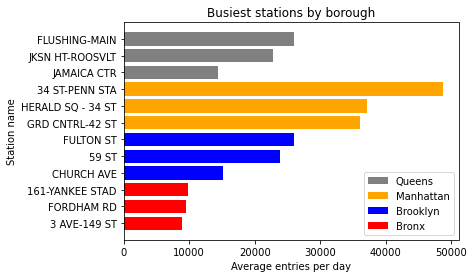

In [108]:
plt.title("Busiest stations by borough")
plt.ylabel("Station name")

plt.xlabel("Average entries per day")

chart = plt.barh(x[::-1],y[::-1], color=["red"]*3+["blue"]*3+["orange"]*3+["grey"]*3)
bars = chart.patches
plt.legend([bars[9], bars[6], bars[3], bars[0]],["Queens","Manhattan","Brooklyn","Bronx"],loc=4)

plt.savefig("top_stations_by_boro.png", bbox_inches="tight")

Now we'll plot the number of overdose deaths per 100000 for each borough for the year 2018

In [109]:
df2018 = op_df[(op_df.year==2018)].sort_values("boro")

In [110]:
x = df2018.boro
y = df2018.deaths_per_100k

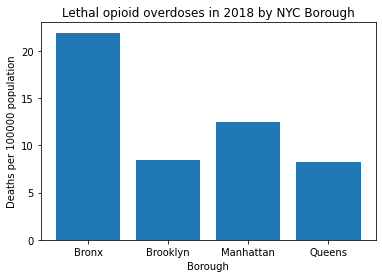

In [111]:
plt.title("Lethal opioid overdoses in 2018 by NYC Borough")
plt.xlabel("Borough")
plt.ylabel("Deaths per 100000 population")

plt.bar(x, y)

plt.savefig("op_deaths_2018.png", bbox_inches="tight")

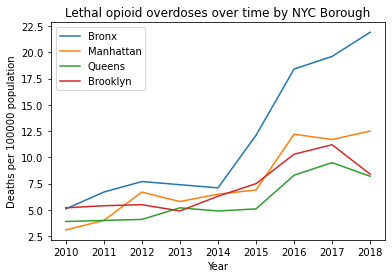

In [112]:
years = [2010, 2011,2012,2013,2014,2015,2016,2017, 2018]
plt.title("Lethal opioid overdoses over time by NYC Borough")
plt.xlabel("Year")
plt.ylabel("Deaths per 100000 population")

for boro in county2boro.values():
    deaths = op_df[op_df.boro ==boro].sort_values("year").deaths_per_100k
    plt.plot(years, deaths, label=boro)

plt.legend()
plt.savefig("op_deaths_time.png", bbox_inches="tight")

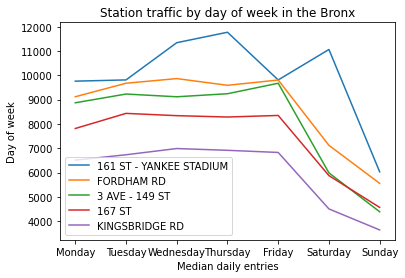

In [119]:
plt.title("Station traffic by day of week in the Bronx")
plt.ylabel("Day of week")

plt.xlabel("Median daily entries")

days_of_week = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday", "Sunday")
top_stations = station_totals[station_totals.boro=="Bronx"].sort_values("DAILY_ENTRIES",ascending = False).head().FOREIGN_KEY

for station in top_stations:
    traffic = [station_daily.DAILY_ENTRIES[
                (station_daily.FOREIGN_KEY==station) & (station_daily.DAY_OF_WEEK == day)].median()
               for day in days_of_week]
    plt.plot(days_of_week, traffic, label=station)

plt.legend(loc = 3)

plt.savefig("station_traffic_day.png", bbox_inches="tight")

In [120]:
top_stations = station_totals[station_totals.boro=="Bronx"].sort_values("DAILY_ENTRIES",ascending = False).head()
top_stations = geopandas.GeoDataFrame(top_stations, geometry=top_stations.geometry)
top_stations.dtypes

STATION            object
DAILY_ENTRIES     float64
NAME               object
FOREIGN_KEY        object
boro               object
geometry         geometry
dtype: object

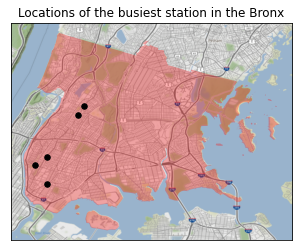

In [121]:
base = boro_df[boro_df.index=="Bronx"].plot(color="red",alpha=.3)


plt.xticks([])
plt.yticks([])
plt.title("Locations of the busiest station in the Bronx")
top_stations.plot(ax=base, marker='o', color='black', markersize=30);

ctx.add_basemap(base, attribution=False, crs=boro_df.crs.to_string())

plt.savefig("station_locations.png", dpi=900, bbox_inches="tight")

In [116]:
top_stations

,STATION,DAILY_ENTRIES,NAME,FOREIGN_KEY,boro,geometry
47,161/YANKEE STAD,9827.5,161-YANKEE STAD,161 ST - YANKEE STADIUM,Bronx,POINT (-73.92569 40.82823)
50,FORDHAM RD,9464.5,FORDHAM RD,FORDHAM RD,Bronx,POINT (-73.89775 40.86130)
53,3 AV-149 ST,8935.5,3 AVE-149 ST,3 AVE - 149 ST,Bronx,POINT (-73.91779 40.81603)
60,167 ST,8065.0,167 ST,167 ST,Bronx,POINT (-73.91843 40.83377)
76,KINGSBRIDGE RD,6662.5,KINGSBRIDGE RD,KINGSBRIDGE RD,Bronx,POINT (-73.89351 40.86698)


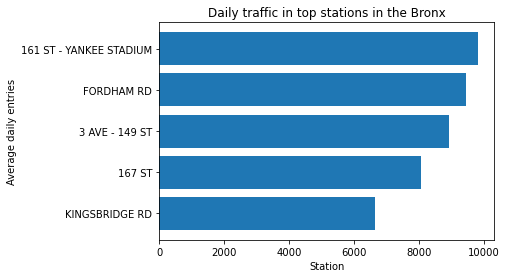

In [117]:
x = top_stations.FOREIGN_KEY
y = top_stations.DAILY_ENTRIES

plt.title("Daily traffic in top stations in the Bronx")
plt.xlabel("Station")
plt.ylabel("Average daily entries")

plt.barh(x[::-1], y[::-1])

plt.savefig("bronx_top_stations.png", bbox_inches="tight")